# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [38]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from model import LeastSquaresMixture
from math import floor

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [39]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split()

Loading data set...
Data loaded.


## Data processing

In [40]:
N = 1000
N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 500
n_samples = 25
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)

N_projects = sk.choose_n_projects(n=N, seed=seed)
projects_train = N_projects[:N_train]
projects_test = N_projects[N_train:]

# Remove outliers
outlier_threshold = 10  # Ignore the project whose total pledged money if more that o_t times their goal
projects_train = [p for p in projects_train if p.money[T] < outlier_threshold]

X_train = np.ndarray(shape=(len(projects_train), t), buffer=np.array([p.money[samples] for p in projects_train]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train]), axis=1)
X_test = np.ndarray(shape=(len(projects_test), t), buffer=np.array([p.money[samples] for p in projects_test]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
X_max = np.max(X_train, axis=0)
X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
X_test = X_test / X_max[np.newaxis, :]  

print("Training on %s projects" % len(X_train))
print("Testing on %s projects" % len(X_test))
print("Number of features: %s" % n_samples)

Training on 788 projects
Testing on 200 projects
Number of features: 25


(array([ 393.,  331.,   33.,   13.,    4.,    5.,    4.,    2.,    2.,    1.]),
 array([ 0.    ,  0.8335,  1.667 ,  2.5005,  3.334 ,  4.1675,  5.001 ,
         5.8345,  6.668 ,  7.5015,  8.335 ]),
 <a list of 10 Patch objects>)

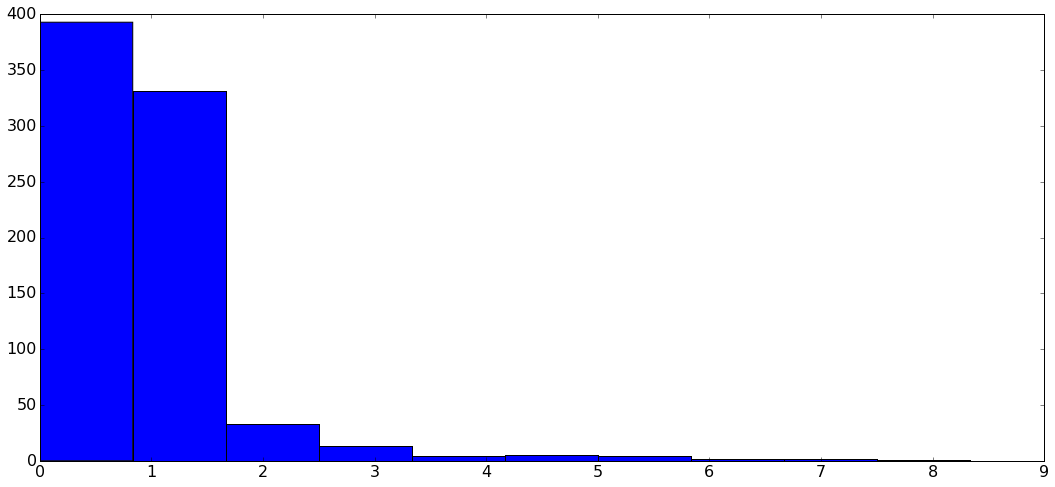

In [41]:
plt.hist(y_train)

## Training

### Grid Search Training

In [56]:
K = 3
epsilon = 1e-2
iterations = 1000
random_restarts = 10
betas = np.array([1/np.var(y_train)])
lambdas = np.logspace(-8, 2, 50)
lambdas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
k_fold = 2

mls = LeastSquaresMixture(X_train, y_train, K=K,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
rmse_avg, rmse_std, accuracy_avg, accuracy_std = mls.grid_search(betas, lambdas, k_fold=k_fold)

print(mls)

Grid Search (7/7): [####################] 100% Elapsed time: 0:00:53
Model:        LeastSquaresMixture (3 components)
Likelihood:   -444.90219238321333
Beta:         5.586793111570529
Lambda:       10.0
Pi:           [  2.67509537e-03   9.97323956e-01   9.48458937e-07]
Weights norm: [0.059885965547636033, 1.9106904072563196, 2.3500061779252556e-05]



### Simple Training

In [138]:
K = 7
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e-4
lam = 0.01
iterations = 1000
random_restarts = 50

mls = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls.train(verbose=False, seed=26)

print(mls)

Random restarts (50/50): [####################] 100% Elapsed time: 0:02:04
Model:        LeastSquaresMixture (7 components)
Likelihood:   131.74328913178996
Beta:         124.79841294612888
Lambda:       0.01
Pi:           [ 0.2131042   0.2003487   0.06870471  0.14772062  0.18863237  0.00514362
  0.17634579]
Weights norm: [5.8262504104570807, 3.6229247177347172, 2.8655613933144521, 3.0591087840494056, 7.3163097878613277, 4.349309515884733, 3.9336262313417794]



## Testing

### Full Test Set

In [139]:
rmse, accuracy, chosen = mls.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (7 components)...
Data point (200/200): [####################] 100% Elapsed time: 0:00:02
Accuracy: 0.815
RMSE    : 17.8441633571
Chosen  : Counter({0: 100, 1: 42, 4: 34, 6: 16, 3: 5, 2: 2, 5: 1})


### Single Point

In [147]:
test = 1
x_new = X_test[test]
y_new, y_posteriors = mls.predict(x_new, posteriors=True)
print("Predicted:  %s" % y_new[0])
print("Posteriors: %s" % ["%0.2f%%" % (p * 100) for p in y_posteriors])
print("Actual:     %s" % y_test[test])

Predicted:  [ 0.05484403  0.93014891  0.06743356  0.03040389  0.02872647  1.18027533
  0.03309206]
Posteriors: ['25.77%', '0.00%', '8.03%', '19.07%', '24.44%', '0.00%', '22.69%']
Actual:     [ 0.01470588]


## Plots

### 0-1 Loss

In [ ]:
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(1 - np.array(accuracy_avg), interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.colorbar()
plt.xticks(np.arange(len(betas)), ["%s" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.title('0-1 Loss')
plt.show()

In [ ]:
plt.errorbar(list(lambdas), [1-a[0] for a in accuracy_avg], yerr=[a[0] for a in accuracy_std])
plt.xscale('log')
plt.title("0-1 Loss (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("0-1 Loss")
plt.show()

### RMSE

In [ ]:
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(rmse_avg, interpolation='nearest')
plt.xticks(np.arange(len(betas)), ["%0.4f" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.colorbar()
plt.title('RMSE')
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.show()

In [ ]:
plt.errorbar(list(lambdas), [r[0] for r in rmse_avg], yerr=[r[0] for r in rmse_std])
plt.xscale('log')
plt.title("RMSE (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("RMSE")
plt.show()